In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import time

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [31]:

def calculate_metrics(y_true, y_pred, training_time):
    """평가 지표 계산 함수"""
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'RMSLE': np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'Training_Time': training_time
    }

def train_evaluate_xgb(data, target_col='avgPrice', time_series=True):
    """XGBoost 모델 학습 및 평가 함수"""
    # 데이터 전처리
    data['date'] = pd.to_datetime(data['date'])
    X = data.drop(['date', 'item', target_col], axis=1)
    y = data[target_col]

    # 하이퍼파라미터 그리드 정의
    xgb_params = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],  # 트리 개수 (모델의 복잡성을 결정, 클수록 성능이 좋아질 수 있지만 과적합 가능성 증가)
    'max_depth': [2, 4, 6, 8, 10],  # 각 트리의 최대 깊이 (값이 클수록 더 복잡한 모델 생성, 과적합 가능성 있음)
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],  # 학습률 (작을수록 학습 속도가 느려지지만 일반화 성능 향상 가능)
    'min_child_weight': [1, 2, 3, 4, 5, 7, 10],  # 리프 노드가 분할되기 위한 최소 가중치 (값이 클수록 더 강한 규제가 적용됨)
    'subsample': [0.8, 0.85, 0.9, 0.95],  # 각 트리 학습 시 사용할 샘플 비율 (0.8이면 데이터의 80%를 샘플링)
    'colsample_bytree': [0.8, 0.85, 0.9],  # 각 트리를 생성할 때 사용할 피처의 비율 (0.8이면 전체 피처 중 80%만 사용)
    'gamma': [0, 0.05, 0.1]  # 노드 분할의 최소 손실 감소 값 (값이 클수록 분할이 덜 일어나며, 과적합을 방지할 수 있음)
	}

    # 교차 검증 방식 설정
    if time_series:
        test_size = len(X)//10
        cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
    else:
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1030)

    # 모델 및 그리드서치 설정
    xgb = XGBRegressor(random_state=1030, n_jobs=-1)
    grid_search = GridSearchCV(
        xgb, xgb_params,
        cv=cv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    # 모델 학습
    start_time = time.time()
    grid_search.fit(X, y)
    training_time = time.time() - start_time

    # # 결과 출력
    # print("\n** Model Performance **")
    # print(f"Best RMSE: {-grid_search.best_score_:.4f}")
    # print("\nBest Parameters:")
    # for param, value in grid_search.best_params_.items():
    #     print(f"{param}: {value}")

    # 예측 및 시각화
    y_pred = grid_search.predict(X)
    plt.figure(figsize=(15, 7))
    plt.plot(data['date'], y, label='Actual', color='blue')
    plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
    plt.title('Actual vs Predicted Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



    # 특정 항목별 그래프 생성
    columns_to_filter = [
        "m_가락시장", "m_강서농수산물시장", "m_구리농수산물시장", "m_노량진 1층", "m_노량진 2층",
        "m_마포농수산물시장", "m_부산민락어민활어직판장", "m_소래포구종합어시장", "m_수원농수산물시장",
        "m_안양평촌농수산물시장", "m_인천종합연안부두어시장"
    ]


    metrics_by_market = {}  # 시장별 성능 저장

    for col in columns_to_filter:
        filtered_data = data[data[col] == 1]
        filtered_y = y[data[col] == 1]
        filtered_y_pred = y_pred[data[col] == 1]

        if not filtered_data.empty:  # 해당 조건에 데이터가 있는 경우만 실행
            # RMSE와 R2 계산
            rmse = np.sqrt(mean_squared_error(filtered_y, filtered_y_pred))
            r2 = r2_score(filtered_y, filtered_y_pred)
            mae = mean_absolute_error(filtered_y, filtered_y_pred)
            mape = np.mean(np.abs((filtered_y - filtered_y_pred) / filtered_y))*100
            
            metrics_by_market[col] = {'RMSE': rmse, 'R2': r2, 'MAE': mae, 'MAPE': mape}

            # 그래프 생성
            plt.figure(figsize=(15, 7))
            plt.plot(filtered_data['date'], filtered_y, label=f'Actual ({col})', color='blue')
            plt.plot(filtered_data['date'], filtered_y_pred, label=f'Predicted ({col})', color='red', linestyle='--')
            plt.title(f'Actual vs Predicted Price ({col})')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


    # # 조건에 맞는 데이터 필터링 (m_가락시장 == 1)
    # filtered_data = data[data['m_가락시장'] == 1]
    # filtered_y = y[data['m_가락시장'] == 1]
    # filtered_y_pred = y_pred[data['m_가락시장'] == 1]

    # # 필터링된 데이터 시각화
    # plt.figure(figsize=(15, 7))
    # plt.plot(filtered_data['date'], filtered_y, label='Actual (m_가락시장=1)', color='blue')
    # plt.plot(filtered_data['date'], filtered_y_pred, label='Predicted (m_가락시장=1)', color='red', linestyle='--')
    # plt.title('Actual vs Predicted Price (m_가락시장=1)')
    # plt.xlabel('Date')
    # plt.ylabel('Price')
    # plt.legend()
    # plt.grid(True)
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()



    # 최종 메트릭 계산 및 출력
    metrics = calculate_metrics(y, y_pred, training_time)
    print("\nFinal Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")


    # 시장별 성능 출력
    print("\n** Market-wise Metrics **")
    for market, metrics in metrics_by_market.items():
        print(f"{market}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}, MAE = {metrics['MAE']:.4f}, MAPE = {metrics['MAPE']:.4f}")
        


	# print(grid_search.best_estimator_)
    #     print(grid_search.best_params_)


    return grid_search.best_estimator_



    # return grid_search.best_estimator_



Fitting 5 folds for each of 37800 candidates, totalling 189000 fits


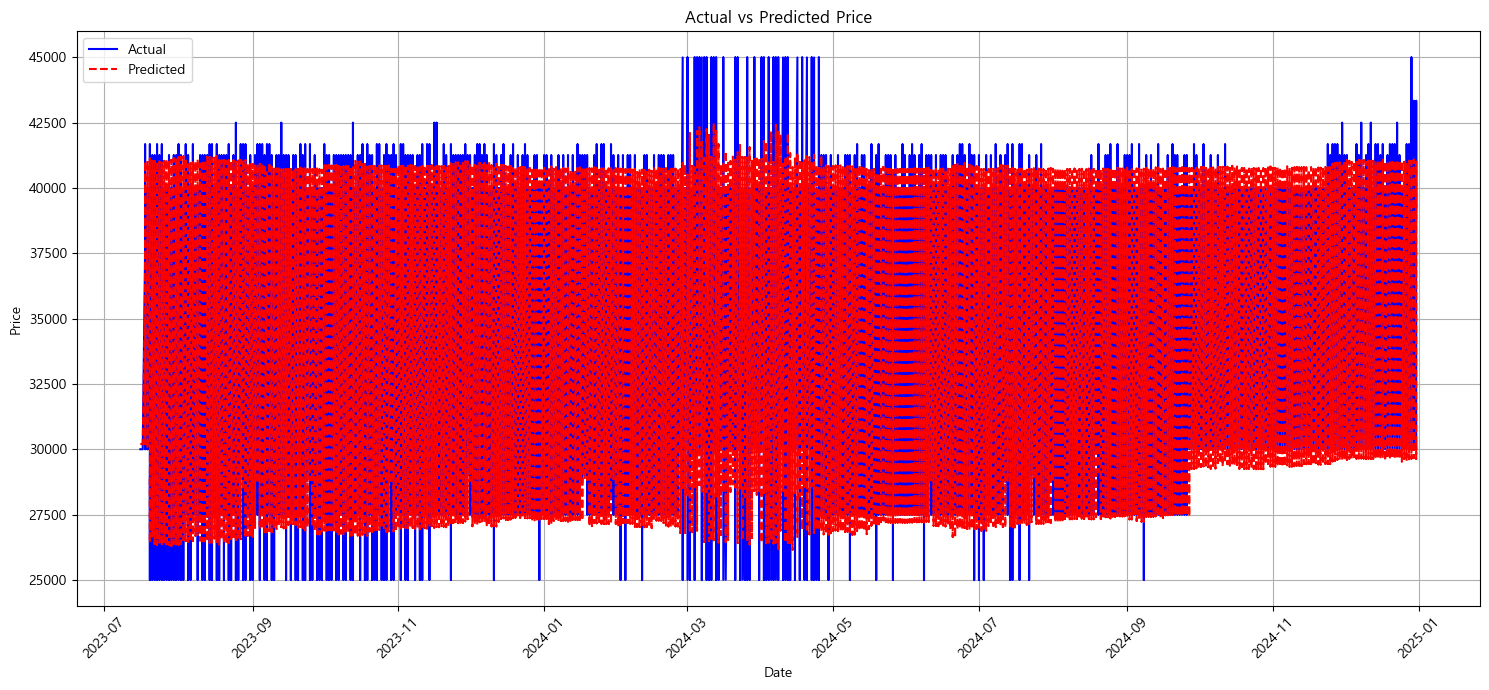

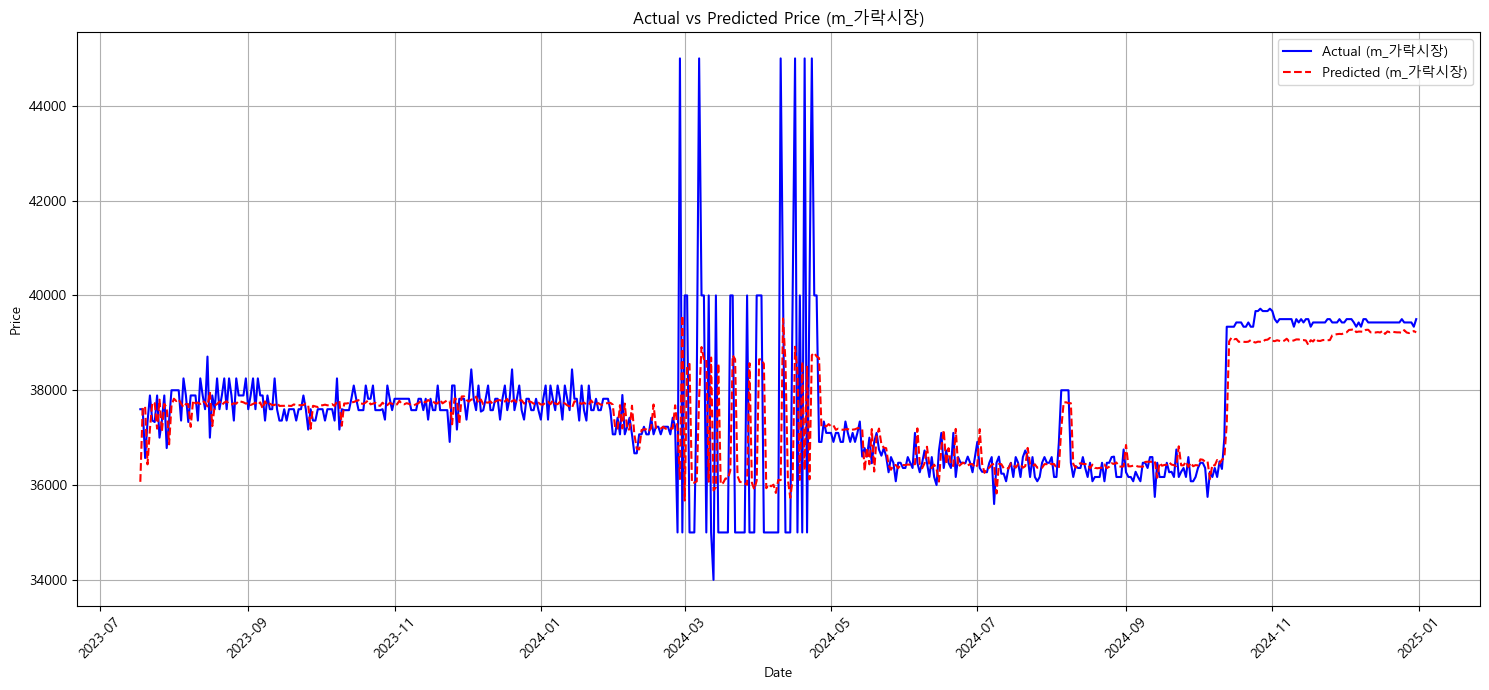

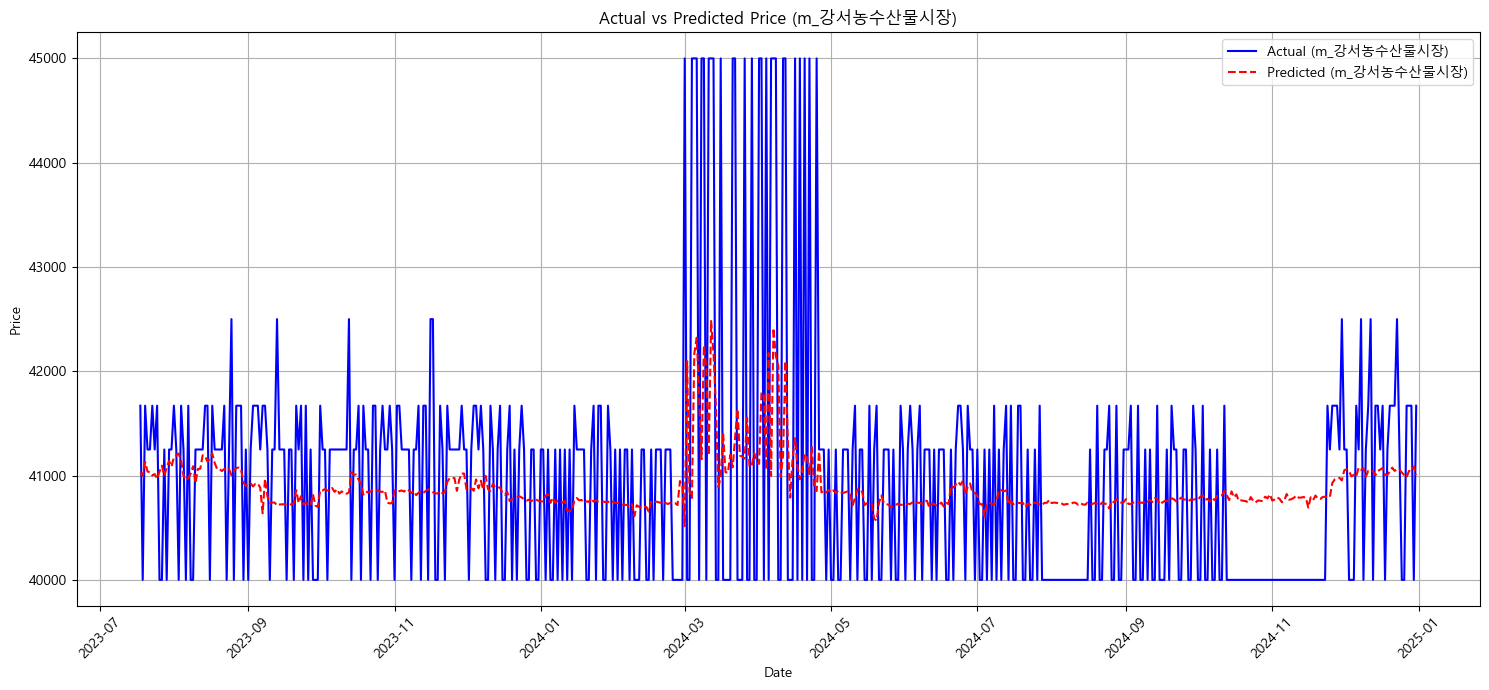

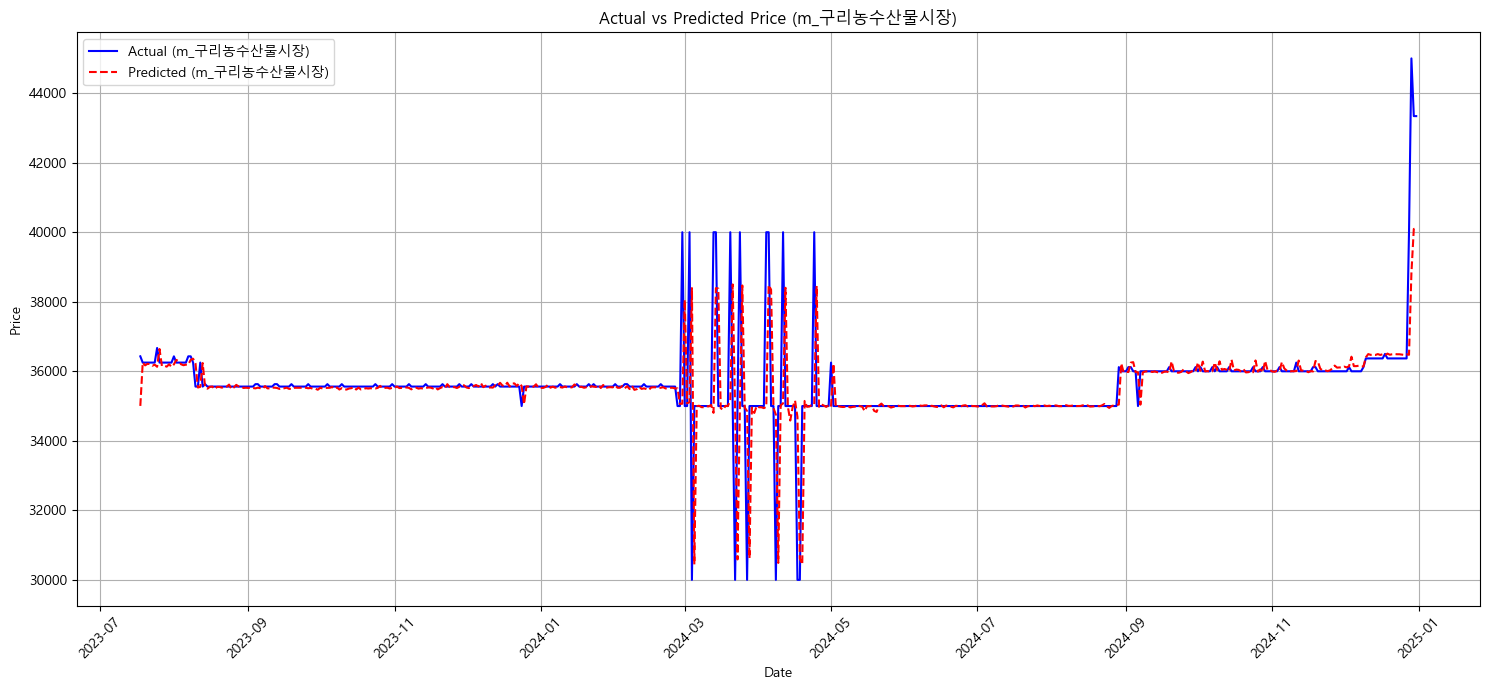

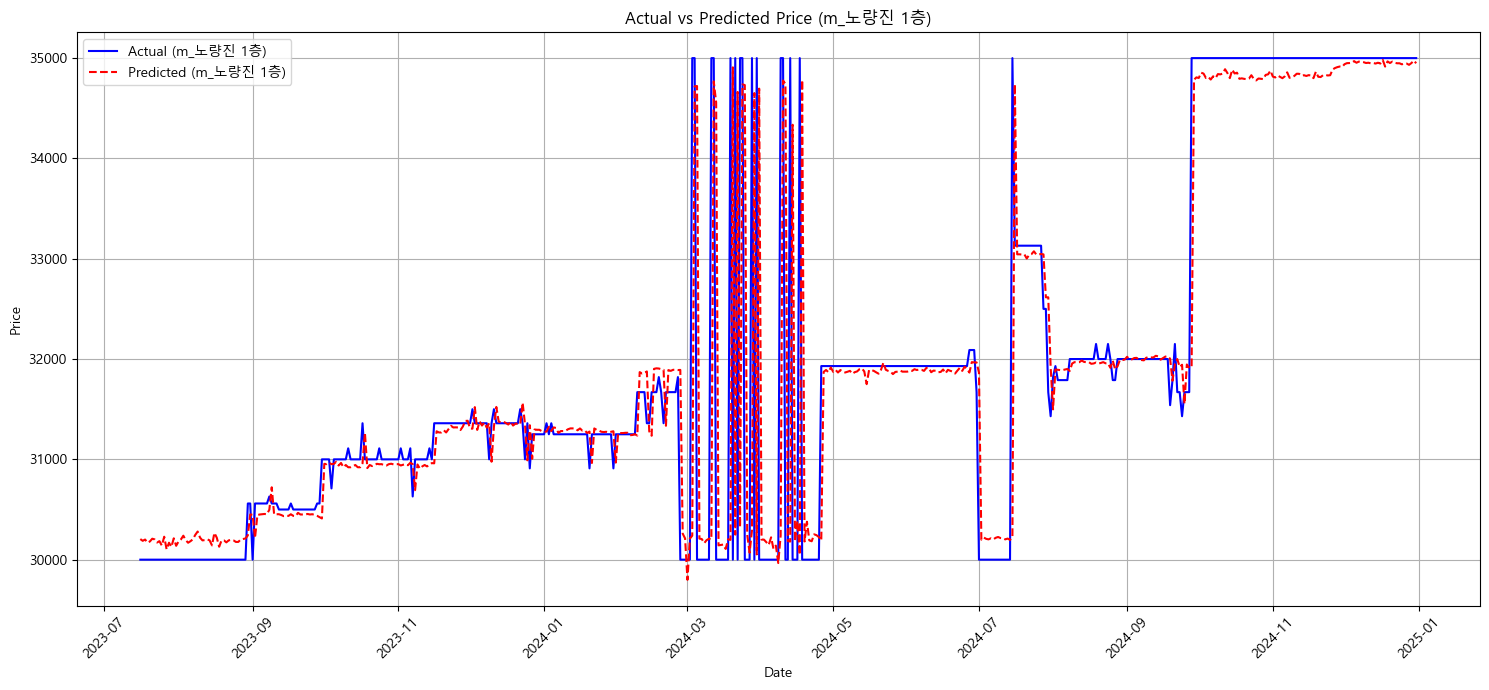

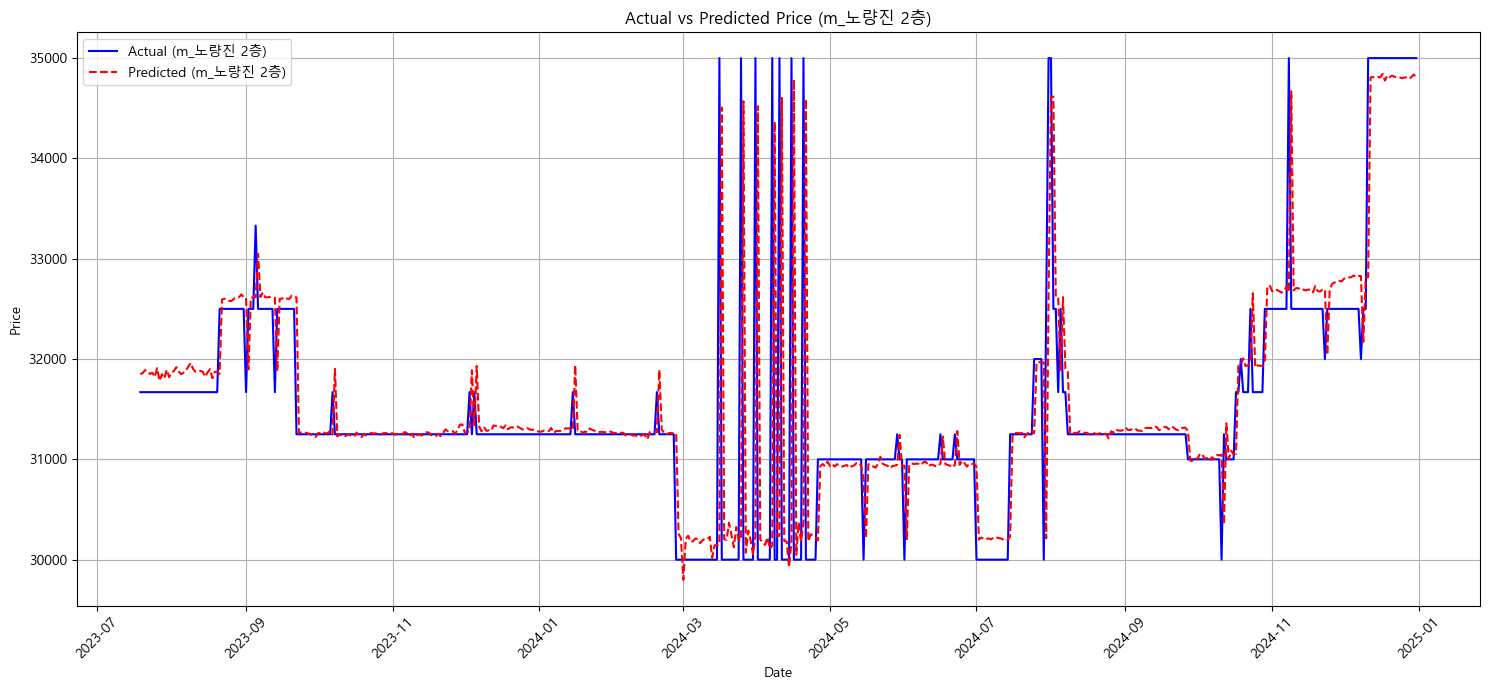

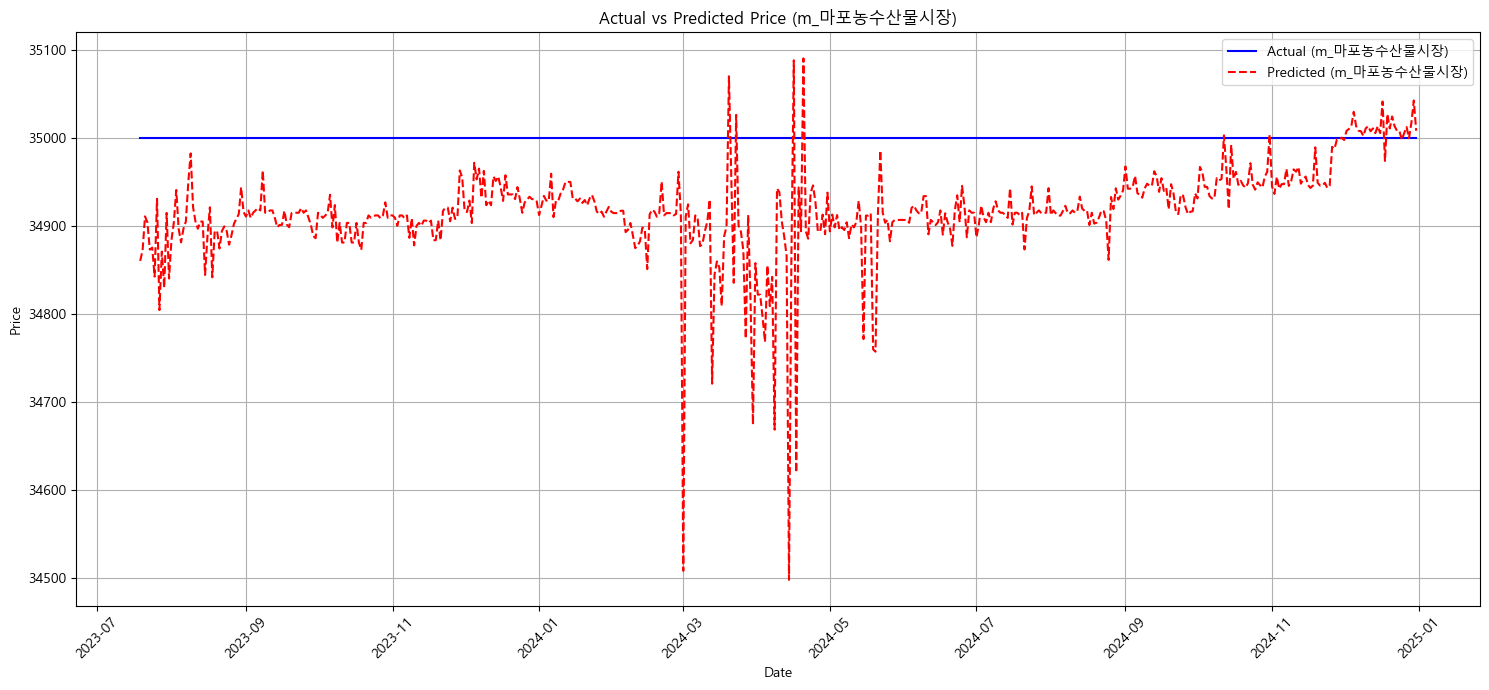

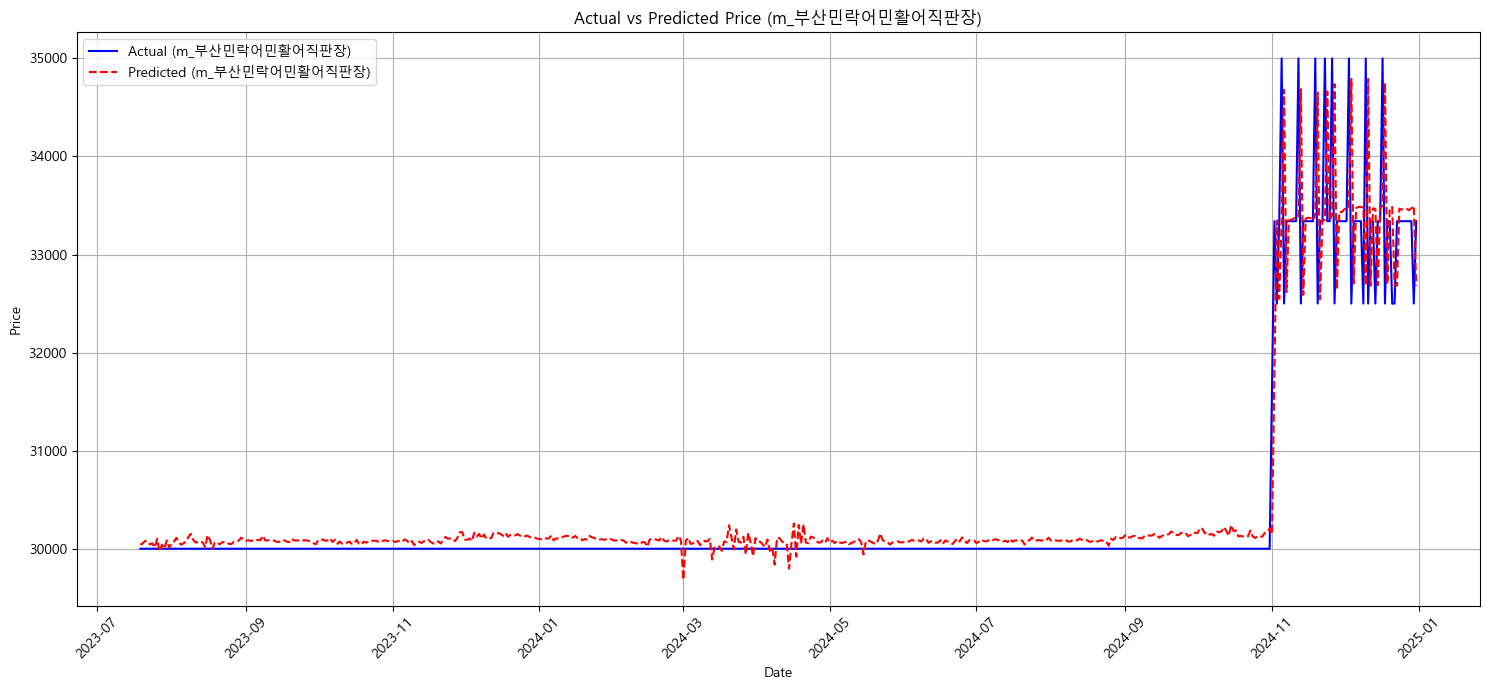

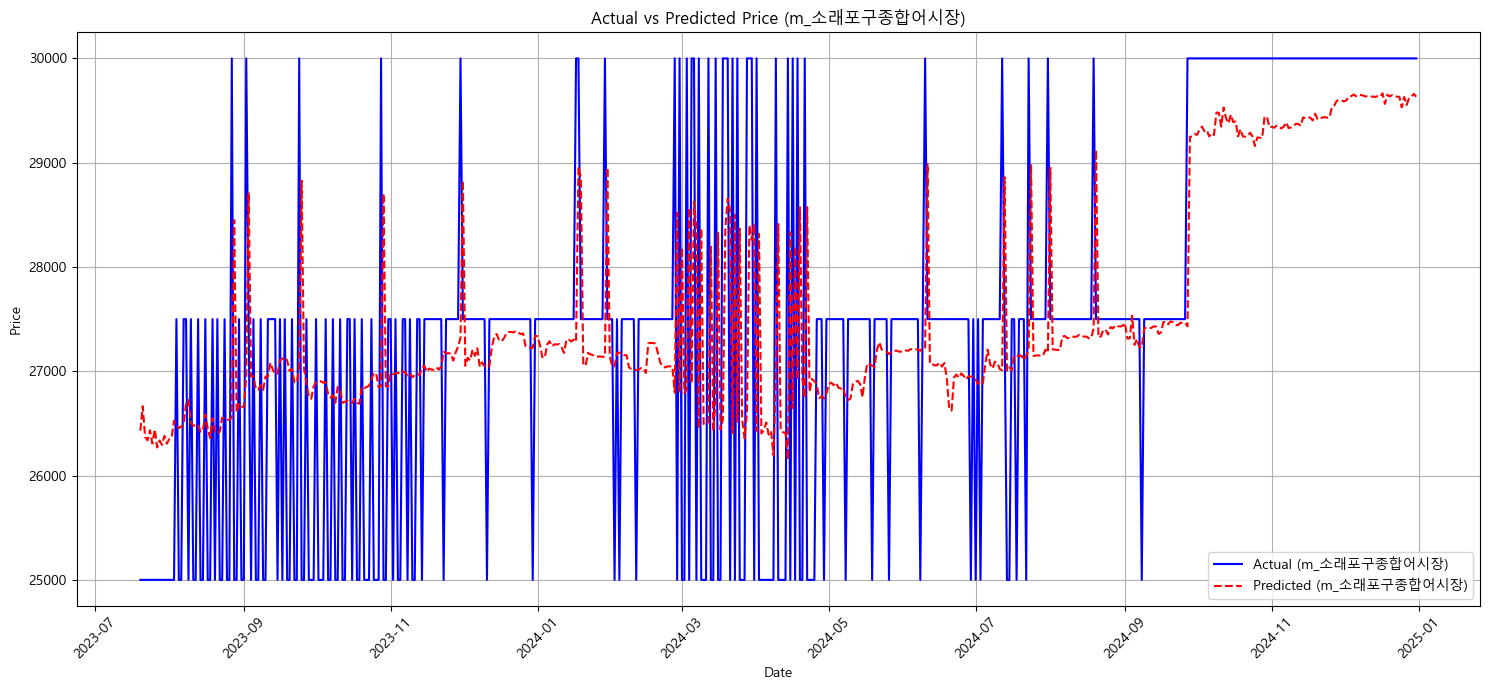

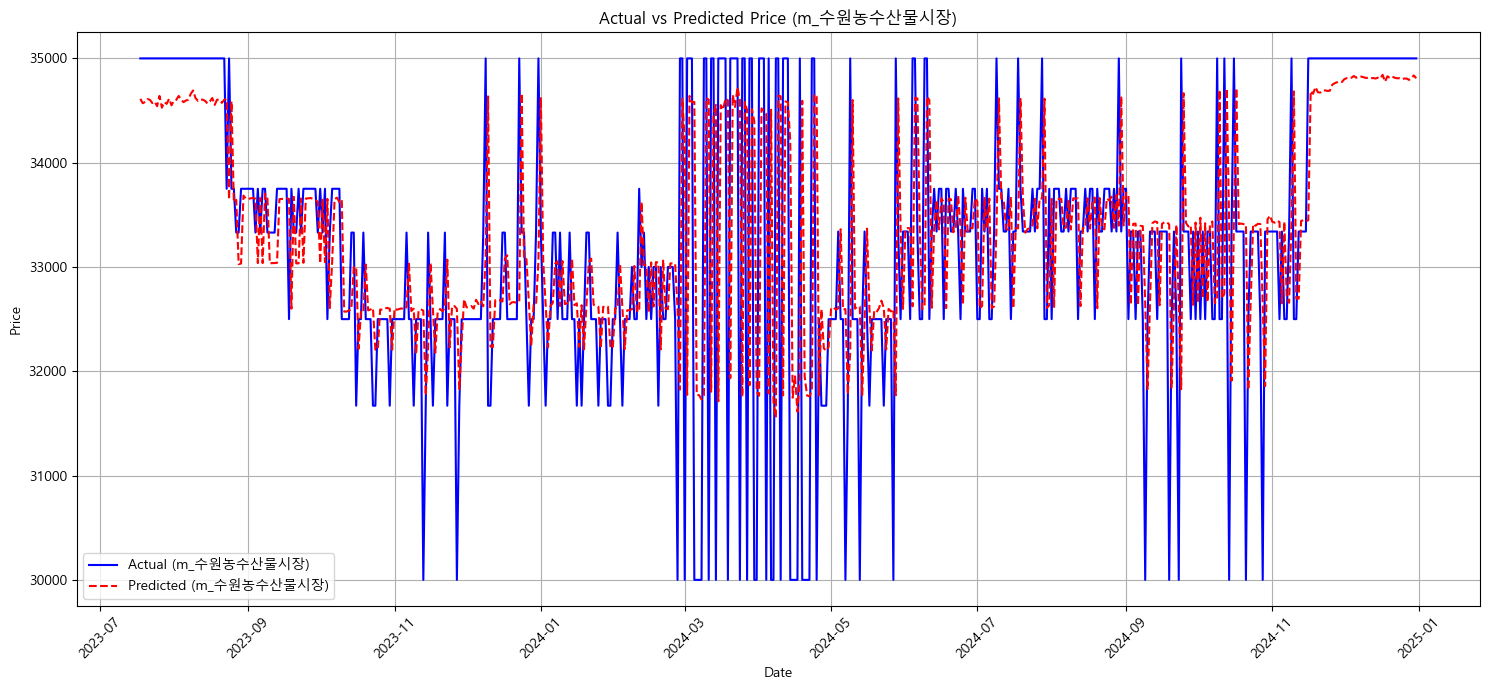

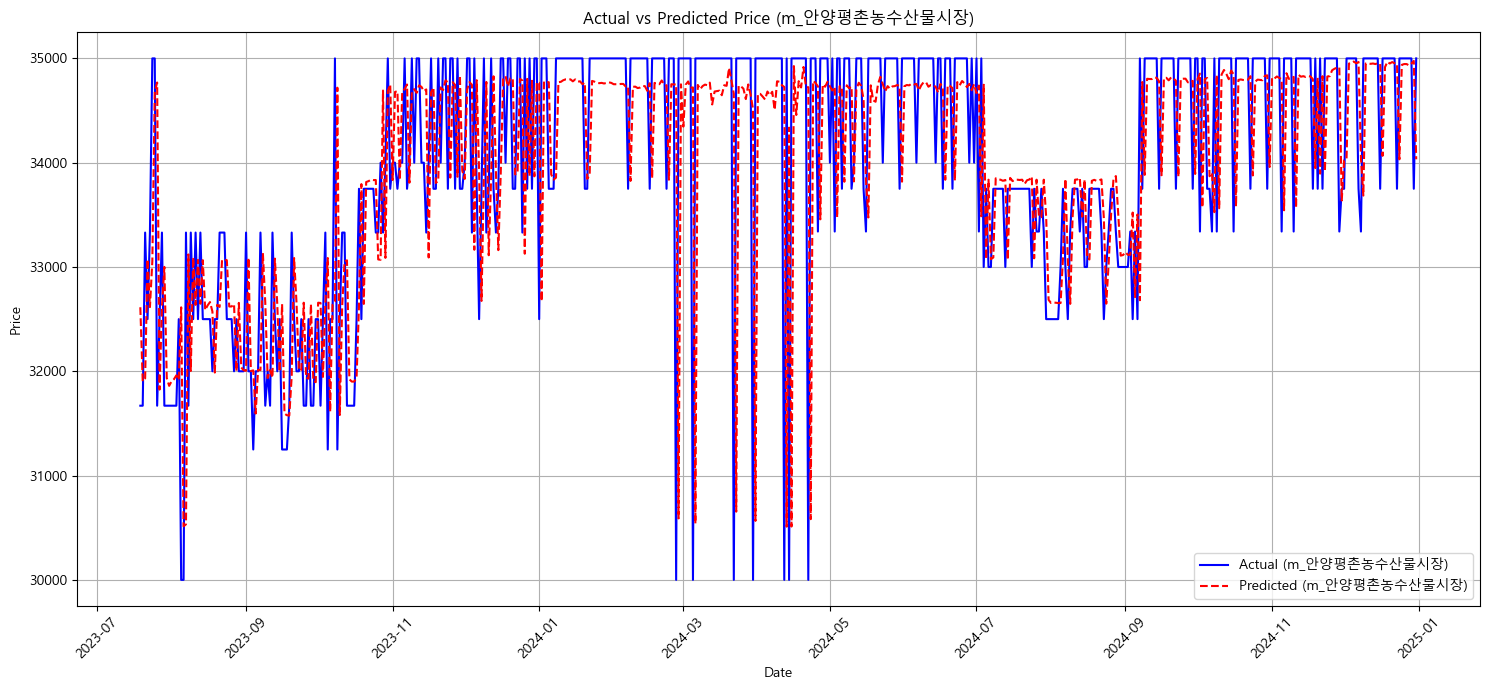

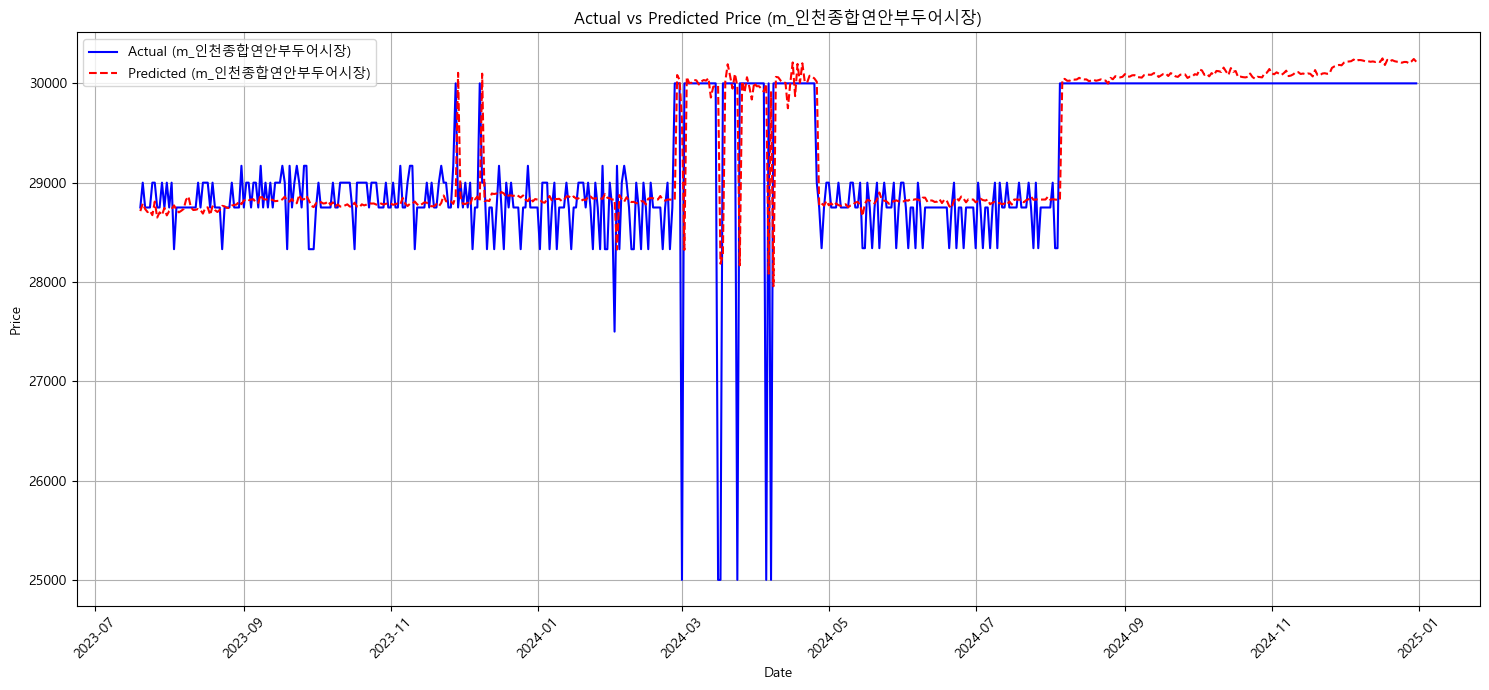


Final Metrics:
MAE: 476.8353
MSE: 953214.6390
RMSE: 976.3271
R2: 0.9371
RMSLE: 0.0297
MAPE: 1.4484
Training_Time: 31604.9299

** Market-wise Metrics **
m_가락시장: RMSE = 1205.5311, R2 = 0.3543, MAE = 553.9921, MAPE = 1.4468
m_강서농수산물시장: RMSE = 1107.5471, R2 = 0.1226, MAE = 857.5630, MAPE = 2.0671
m_구리농수산물시장: RMSE = 1088.5255, R2 = 0.1129, MAE = 320.2746, MAPE = 0.8909
m_노량진 1층: RMSE = 974.6446, R2 = 0.6793, MAE = 323.8349, MAPE = 1.0072
m_노량진 2층: RMSE = 837.1751, R2 = 0.4274, MAE = 297.0953, MAPE = 0.9278
m_마포농수산물시장: RMSE = 97.6018, R2 = 0.0000, MAE = 84.1993, MAPE = 0.2406
m_부산민락어민활어직판장: RMSE = 386.1443, R2 = 0.8762, MAE = 173.6210, MAPE = 0.5483
m_소래포구종합어시장: RMSE = 1366.2223, R2 = 0.3970, MAE = 995.1451, MAPE = 3.7095
m_수원농수산물시장: RMSE = 1229.4754, R2 = 0.1660, MAE = 753.0668, MAPE = 2.3158
m_안양평촌농수산물시장: RMSE = 1044.7776, R2 = 0.2427, MAE = 653.2206, MAPE = 1.9509
m_인천종합연안부두어시장: RMSE = 582.2268, R2 = 0.4224, MAE = 233.4700, MAPE = 0.8310


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=1030, ...)

In [32]:
data = pd.read_csv('../../../data/features/final_oneHot/우럭_price_features_notnull.csv')
model = train_evaluate_xgb(data, target_col='avgPrice', time_series=True)

In [38]:
import joblib  # 모델 저장을 위한 라이브러리

# 데이터 로드
data = pd.read_csv('../../../data/features/final_oneHot/우럭_price_features_notnull.csv')

# 모델 학습 및 반환
model = train_evaluate_xgb(data, target_col='avgPrice', time_series=True)

# 학습된 모델 저장
joblib.dump(model, 'xgb_model.joblib')  # 모델을 'xgb_model.joblib' 파일에 저장
print("학습된 모델이 'xgb_model.joblib'로 저장되었습니다.")

NameError: name 'model' is not defined

In [ ]:
from xgboost import XGBRegressor

# 저장된 모델 로드
loaded_model = XGBRegressor()
loaded_model.load_model('xgb_model.json')
print("모델이 성공적으로 로드되었습니다.")